- [ ] Need to run this file to save avg(Te) for changing R_outs, avg($\rho$), avg(Pg), avg(bsq) for MAD and SANE

Note: 1) Due to some constraint on computation memory, some of the code encountered "kernel died" when they were run again, so some of the plots didn't show up. The latter half of the code ran with only a few cells at a time and then with kernel restarted. <br> This time, try every 20 slices as one interval $[tried; still \space messy]$ <br> Try $\textbf{40}$ slices as an interval  due to memory constraint$[emmm, somehow \space better]$

P.S.: the "vmax" in MI plots are set up for visual purposes; check its statistics for accurate info

path: 

/xdisk/chanc/share/

there are two folders: GRMHD_dt1000M and GRMHD_dt10M

under GRMHD_dt1000M: Ma+0.5_w5  Ma+0.94_w5  Ma-0.5_w5  Ma-0.94_w5  Ma0_w5  Sa+0.5_w5  Sa+0.94_w5  Sa-0.5_w5  Sa-0.94_w5  Sa0_w5

under GRMHD_dt10M: Ma+0.94_w5  Ma-0.94_w5  Sa+0.94_w5, 5000 - 5999

### electron temperature:

eqn 27 of https://arxiv.org/pdf/2202.11721.pdf: $Te = \frac{m_{p}u(\gamma_{e}-1)(\gamma_{i}-1)}{k \rho (y(\gamma_{i}-1)+Rz(\gamma_{e}-1))}$ where: <br> y and z are the number of electrons and nucleons per unionized atom, respectively <br> eqn 22 $R = \frac{R_{low}}{1+\widetilde{\beta}^{2}}+ \frac{R_{high}\widetilde{\beta}^{2}}{1+\widetilde{\beta}^{2}}$ and $\widetilde{\beta} = \frac{\beta}{\beta_{crit}}$, assume $\beta_{crit}=1$. Try $R_{high}=1, 10, 40, 160$; $R_{low}=1$ <br> 

look for γ: https://arxiv.org/pdf/2202.11721.pdf <br> Assume ideal gas -> $Γ = \frac{5}{3} + \frac{4}{3}(1 - x_{e})$ where $x_{e}$ is the electron fraction. <br> 
$\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> 
$\gamma = \frac{13}{9}$, $x_{e} = \frac{1}{3}$, so ions:electrons = 2:1 (y=1, z=2; $\gamma_{i}=\gamma=\frac{13}{9}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{133}{36}$) <br> 
$\gamma = \gamma_{i}=\frac{5}{3}$, so the gas is fully composed of ions (i.e. $\gamma_{e} = 0$) (? y=z=1; $\gamma_{i}=\gamma_{e} = \gamma = \frac{5}{3}$) <br>

For non-uniform $\gamma$: https://www.aanda.org/articles/aa/full_html/2015/08/aa26247-15/aa26247-15.html

We assume uniform $\gamma$ in the following simulations. <br>

Variance plot $(Te - <Te>)^{2}|_{calculated}$

In [1]:
import warnings

from toolz import valmap

import h5py
import pyharm

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyharm.plots import plot_dumps as pplt

In [2]:
print(pyharm.units)

<module 'pyharm.units' from '/home/u12/limengjiang/.local/lib/python3.8/site-packages/pyharm/units.py'>


In [3]:
pyharm.units.get_cgs()

{'CL': 29979245800.0,
 'QE': 4.8032068e-10,
 'EE': 4.8032068e-10,
 'ME': 9.1093826e-28,
 'MP': 1.67262171e-24,
 'MN': 1.67492728e-24,
 'HPL': 6.6260693e-27,
 'HBAR': 1.0545717e-27,
 'KBOL': 1.3806505e-16,
 'GNEWT': 6.6742e-08,
 'SIG': 5.6704e-05,
 'AR': 7.5657e-15,
 'THOMSON': 6.65245873e-25,
 'JY': 1e-23,
 'PC': 3.085678e+18,
 'AU': 14959787069100.0,
 'MSOLAR': 1.989e+33,
 'RSOLAR': 69600000000.0,
 'LSOLAR': 3.827e+33}

In [3]:
i0 = 5010 # initial  frame
i1 = 5051 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

## Electron Temperature Variance Plot(s)

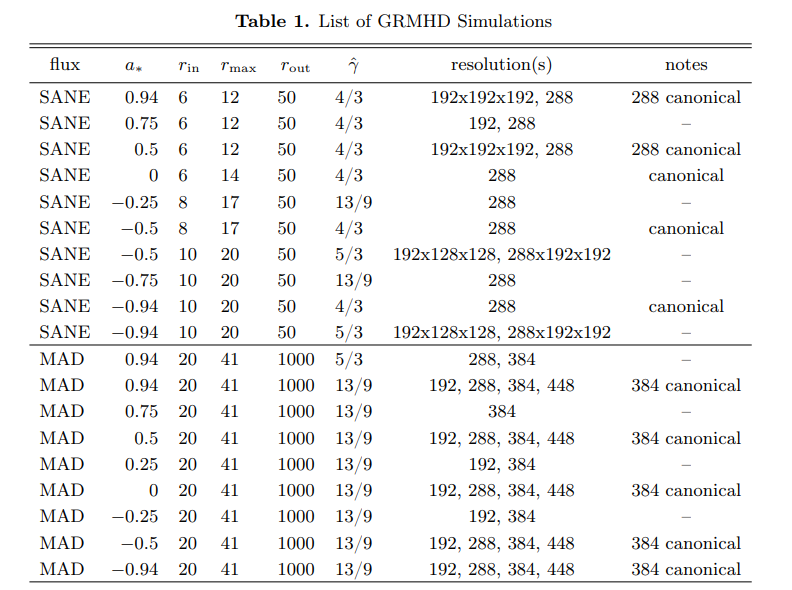

In [5]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16

In [6]:
# R
def R(dump, Rh, Rl):
    # with warnings.catch_warnings(record=True) as w:
    '''
    try: 
        beta = dump['beta']
    except RuntimeWarning as warning:
        if str(warning) == "divide by zero encountered in true_divide":
            beta = np.zeros(dump['Pg'])
    '''
    beta = dump['beta']
    return Rl/(1+beta**2)+Rh*beta**2/(1+beta**2)

In [7]:
# electron temperature
def Te(dump, Rh, Rl, gamma):
    if gamma == 4/3:
        y = 1
        z = 3
        gamma_i = 4/3
        gamma_e = 7/3
    if gamma == 13/9:
        y = 1
        z = 2
        gamma_i = 13/9
        gamma_e = 133/36
    if gamma == 5/3:
        y = 1
        z = 1
        gamma_i = 5/3
        gamma_e = 5/3
    beta = dump['beta']
    u = dump['Pg']/(gamma-1)
    r = R(dump, Rh, Rl)
    numerator = mp*cl**2*u*(gamma_e-1)*(gamma_i-1)
    denom = kb*dump['RHO']*(y*(gamma_i-1)+r*z*(gamma_e-1))
    '''
    try:
        electron_T = numerator/ denom
    except RuntimeWarning as warning:
        if str(warning) == "invalid value encountered in true_divide":
            electron_T = np.full(numerator.shape, 10**10)
    '''
    electron_T = numerator/ denom
    dump.cache['Te'] = electron_T
    return electron_T

In [8]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

R_low = 1.
R_high = [1, 10, 40, 160]

In [9]:
print(fname(i0, src_ma_10M))

/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/torus.out0.05010.h5


In [10]:
import os
from datetime import datetime

file_path = fname(i0, src_ma_10M)

last_modified_timestamp = os.path.getmtime(file_path)
dt_object = datetime.fromtimestamp(last_modified_timestamp)
print(f"Last modified time: {dt_object}")

Last modified time: 2021-05-24 21:05:02


In [11]:
dump0 = pyharm.load_dump(fname(i0, src_ma_10M))

In [12]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

In [13]:
def average(irange, keys, dumps):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [14]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: np.zeros_like(dump0['Pg'])}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    print('finish variance calculation\'s loop')
    return valmap(lambda v: v/len(irange), ss)

In [15]:
def average_rho(irange, keys, dumps):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)]
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [16]:
def get_statistics(dumps, quality):
    """
    dumps: the dumps' dictionary in the format of dumps={'5010':arr1, '5011':arr2, etc}
    quality: string, the quality whose statistics we want 
    """
    print('statistics on ' + quality + ':')
    print('max ' + quality + ':')
    maximum = np.max(dumps[str(i0)].cache[quality])
    print("{:e}".format(maximum))
    print('percentile on ' + quality+ ' [50%, 75%, 90%]:')
    # percentile of the flattened grid
    percentile = np.percentile(dumps[str(i0)].cache[quality], [50, 75, 90])
    print(percentile)

### Same $\gamma$ Under the same model -> Same avgPg, avgbsq & MI
### Same file -> same Pg, bsq
### one set of avgPg and avgbsq (& MI) project to four sets of Te for one file, one time interval?

# $\gamma = \frac{4}{3}$

<h5>MAD model, $R_{high} = 1$ </h5>

<h5>Te</h5>

In [18]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [19]:
# electron temperature, mad model, R_high = 1
Te_mad_rh1 = {} 
dict_keys = dumps.keys()
# loop through each dump file and calculate Te
for key in dict_keys:
    Te_ma = Te(dumps[key], R_high[0], R_low, 4/3)
    Te_mad_rh1[key] = Te_ma

In [20]:
# average
Te_Ma_avg1 = average(range(i0, i1), ['Te'], dumps)
'''
for dump in dumps.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Ma_avg1.values())))
'''

finish average calculation.


"\nfor dump in dumps.values():\n    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Ma_avg1.values())))\n"

In [21]:
print(dumps[str(i0)].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te'])


In [26]:
np.save("ma_rh1_avgTe.npy", Te_Ma_avg1)

<h5>Pg</h5>

In [18]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [19]:
for dump in dumps.values():
    dump['Pg']

In [20]:
# It looks like RHO is not in dump.cache; instead, it's in dump. So, use 'Pg' as a substitute
Pg_Ma_avg1 = average(range(i0, i1), ['Pg'], dumps)

finish average calculation.


In [21]:
np.save("ma_avgPg.npy", Pg_Ma_avg1)

<h5>bsq</h5>

In [14]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [15]:
for dump in dumps.values():
    dump['bsq']

In [16]:
B2_Ma_avg1 = average(range(i0, i1), ['bsq'], dumps)

finish average calculation.


In [17]:
np.save("ma_avgbsq.npy", B2_Ma_avg1)

<h5>$\rho$</h5>

In [18]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [19]:
for dump in dumps.values():
    dump['RHO']

In [20]:
rho_Ma_avg1 = average_rho(range(i0, i1), ['RHO'], dumps)

finish average calculation.


In [21]:
np.save("ma_avgRHO.npy", rho_Ma_avg1)

In [18]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [19]:
for dump in dumps.values():
    dump.cache['R'] = R(dump, R_high[0], R_low)

In [20]:
R_Ma_avg1 = average(range(i0, i1), ['R'], dumps)
np.save('ma_avgR1.npy', R_Ma_avg1)

finish average calculation.


<h5>Cross terms</h5>

In [16]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [16]:
# to avoid empty dictionaries
for dump in dumps.values():
    dump['Pg']

In [17]:
for dump in dumps.values():
    dump.cache['rhoPg'] = dump['RHO'] * dump.cache['Pg']

In [18]:
rhoPg_Ma_avg = average(range(i0, i1), ['rhoPg'], dumps)
np.save("ma_avgRHOPg.npy", rhoPg_Ma_avg)

finish average calculation.


$P_{mag}= \frac{B^{2}}{2\mu_{0}}$ <br>
$\delta P_{mag}=\frac{1}{2\mu_{0}}(\delta B^{2})$ <br>
In cgs units, $\mu_{0}=1$

In [18]:
for dump in dumps.values():
    dump['Pg']
    dump['bsq']

In [19]:
for dump in dumps.values():
    dump.cache['PgPmag'] = dump.cache['Pg'] * 0.5*dump.cache['bsq']

In [20]:
PgPmag_Ma_avg = average(range(i0, i1), ['PgPmag'], dumps)
np.save("ma_avgPgPmag.npy", PgPmag_Ma_avg)

finish average calculation.


In [17]:
for dump in dumps.values():
    dump['bsq']

In [18]:
for dump in dumps.values():
    dump.cache['rhoPmag'] = dump['RHO'] * 0.5*dump.cache['bsq']

In [19]:
rhoPmag_Ma_avg = average(range(i0, i1), ['rhoPmag'], dumps)
np.save("ma_avgRHOPmag.npy", rhoPmag_Ma_avg)

finish average calculation.


<h5>SANE model, $R_{high}$ = 1</h5>

In [16]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [17]:
# electron temperature, sane model, R_high = 1
Te_sa_rh1 = {} 
dict_keys = dumps_sa.keys()
for key in dict_keys:
    Te_sa = Te(dumps_sa[key], R_high[0], R_low, 4/3)
    Te_sa_rh1[key] = Te_sa

In [18]:
# average
Te_Sa_avg1 = average(range(i0, i1), ['Te'], dumps_sa)
'''
for dump in dumps_sa.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Sa_avg1.values())))
    '''

finish average calculation.


"\nfor dump in dumps_sa.values():\n    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Sa_avg1.values())))\n    "

In [19]:
print(dumps_sa[str(i0)].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te'])


In [20]:
np.save("sa_rh1_avgTe.npy", Te_Sa_avg1)

<h5>Pg</h5>

In [16]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [17]:
for dump in dumps_sa.values():
    dump['Pg']

In [18]:
Pg_sa_avg1 = average(range(i0, i1), ['Pg'], dumps_sa)
'''
for dump in dumps_sa.values():
    dump.cache['avgPg'] = np.squeeze(np.array(list(Pg_sa_avg1.values())))
    '''

finish average calculation.


"\nfor dump in dumps_sa.values():\n    dump.cache['avgPg'] = np.squeeze(np.array(list(Pg_sa_avg1.values())))\n    "

In [19]:
np.save("sa_avgPg.npy", Pg_sa_avg1)

<h5>$B^{2}$</h5>

In [16]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [17]:
# dumps_sa = get_dumps(i0, i1, src_sa_10M)
for dump in dumps_sa.values():
    dump['bsq']

In [18]:
B2_sa_avg1 = average(range(i0, i1), ['bsq'], dumps_sa)
'''
for dump in dumps_sa.values():
    dump.cache['avgbsq'] = np.squeeze(np.array(list(B2_sa_avg1.values())))
    '''

finish average calculation.


"\nfor dump in dumps_sa.values():\n    dump.cache['avgbsq'] = np.squeeze(np.array(list(B2_sa_avg1.values())))\n    "

In [19]:
np.save("sa_avgbsq.npy", B2_sa_avg1)

In [26]:
get_statistics(dumps_sa, 'avgbsq')
print()
get_statistics(dumps_sa, 'varbsq')

statistics on avgbsq:
max avgbsq:
7.540685e-02
percentile on avgbsq [50%, 75%, 90%]:
[6.97747035e-06 3.75500511e-04 3.14042188e-03]

statistics on varbsq:
max varbsq:
4.428741e-04
percentile on varbsq [50%, 75%, 90%]:
[1.32988352e-11 4.82110195e-08 1.32228175e-06]


<h5>$\rho$</h5>

In [17]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [18]:
for dump in dumps_sa.values():
    dump['RHO']

In [19]:
rho_sa_avg1 = average_rho(range(i0, i1), ['RHO'], dumps_sa)

finish average calculation.


In [20]:
np.save("sa_avgRHO.npy", rho_sa_avg1)

<h5>Cross terms</h5>

In [17]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [17]:
for dump in dumps_sa.values():
    dump.cache['R'] = R(dump, R_high[0], R_low)

In [19]:
R_sa_avg1 = average(range(i0, i1), ['R'], dumps_sa)
np.save('sa_avgR1.npy', R_sa_avg1)

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump['Pg']

In [20]:
for dump in dumps_sa.values():
    dump.cache['rhoPg'] = dump['RHO'] * dump.cache['Pg']

In [21]:
rhoPg_sa_avg = average(range(i0, i1), ['rhoPg'], dumps_sa)
np.save("sa_avgRHOPg.npy", rhoPg_sa_avg)

finish average calculation.


In [18]:
for dump in dumps_sa.values():
    dump['Pg']
    dump['bsq']

In [19]:
for dump in dumps_sa.values():
    dump.cache['PgPmag'] = dump.cache['Pg'] * 0.5*dump.cache['bsq']

In [20]:
PgPmag_sa_avg = average(range(i0, i1), ['PgPmag'], dumps_sa)
np.save("sa_avgPgPmag.npy", PgPmag_sa_avg)

finish average calculation.


In [20]:
for dump in dumps_sa.values():
    dump['bsq']

In [21]:
for dump in dumps_sa.values():
    dump.cache['rhoPmag'] = dump['RHO'] * 0.5*dump.cache['bsq']

In [22]:
rhoPmag_sa_avg = average(range(i0, i1), ['rhoPmag'], dumps_sa)
np.save("sa_avgRHOPmag.npy", rhoPmag_sa_avg)

finish average calculation.


<h5>MAD, $R_{high}=160$</h5>

In [17]:
dumps = get_dumps(i0, i1, src_ma_10M)

In [18]:
# electron temperature, mad model, R_high = 1
Te_mad_rh160 = {} 
dict_keys = dumps.keys()
for key in dict_keys:
    Te_ma = Te(dumps[key], R_high[3], R_low, 4/3)
    Te_mad_rh160[key] = Te_ma

In [19]:
# average
Te_Ma_avg160 = average(range(i0, i1), ['Te'], dumps)
'''
for dump in dumps.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Ma_avg1.values())))
'''

finish average calculation.


"\nfor dump in dumps.values():\n    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Ma_avg1.values())))\n"

In [20]:
np.save("ma_rh160_avgTe.npy", Te_Ma_avg160)

In [18]:
for dump in dumps.values():
    dump.cache['R'] = R(dump, R_high[3], R_low)

In [19]:
R_ma_avg160 = average(range(i0, i1), ['R'], dumps)
np.save('ma_avgR160.npy', R_ma_avg160)

finish average calculation.


<h5>SANE, $R_{high}$=160</h5>

In [17]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [16]:
# electron temperature, sane model, R_high = 1
Te_sa_rh160 = {} 
dict_keys = dumps_sa.keys()
for key in dict_keys:
    Te_sa = Te(dumps_sa[key], R_high[3], R_low, 4/3)
    Te_sa_rh160[key] = Te_sa

In [17]:
# average
Te_Sa_avg160 = average(range(i0, i1), ['Te'], dumps_sa)

finish average calculation.


In [18]:
np.save("sa_rh160_avgTe.npy", Te_Sa_avg160)

In [18]:
for dump in dumps_sa.values():
    dump.cache['R'] = R(dump, R_high[3], R_low)

In [19]:
R_sa_avg160 = average(range(i0, i1), ['R'], dumps_sa)
np.save('sa_avgR160.npy', R_sa_avg160)

finish average calculation.
